In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
from matplotlib import cm
import sys
import pdb
from copy import deepcopy
from tqdm import tqdm
import astropy.units as u
import mpl_scatter_density

import seaborn as sns
plt.style.use('seaborn')

/var/folders/d7/mj7t5gvn7kxcpnv91gn5rxs5myk4z8/T/ipykernel_26277/2184438354.py:13: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
sys.path.append('/Users/anh5866/Desktop/Coding')
import PyXFocus.sources as sources
import PyXFocus.transformations as trans
import PyXFocus.surfaces as surfaces
import PyXFocus.analyses as analyses
import PyXFocus.conicsolve as conic

import OGRE.ogre_routines_alexplay as ogre

soxs : [WARNING  ] 2025-04-10 13:50:04,168 Setting 'soxs_data_dir' to /Users/anh5866/Library/Caches/soxs for this session. Please update your configuration if you want it somewhere else.


In [3]:
# Define JET-X optic parameters.
z0 = 3500. * u.mm  # Focal length.

d_int = np.array([187.181697, 195.044289, 203.186973, 211.689775, 220.552696, 229.775737, 239.398908, 249.422212, 
                  259.865654, 270.729235, 282.052968, 293.856858]) * u.mm  # Diameter at intersection node.

r_int = d_int/2 #Radius at intersection node


mirror_length = 300 * u.mm  # Axial length of primary / secondary mirror.
mirror_sep = 0 * u.mm  # Separation between primary and secondary mirrors.


# PANTER Parameters
L = (123000. + 12000) * u.mm  # Approximate.
L -= 4000. * u.mm  # Accounts for focal length of optic in the finite conjugate.
#L = 10e12 * u.mm

#wave = 0.98903  # [nm] Mg-K wavelength.
wave = 0.83401 * u.nm # Al-K wavelength.

print(r_int)

print(L)

[ 93.5908485  97.5221445 101.5934865 105.8448875 110.276348  114.8878685
 119.699454  124.711106  129.932827  135.3646175 141.026484  146.928429 ] mm
131000.0 mm


In [4]:
# Define inner and outer subannulus radii.
z_in = z0 + mirror_sep/2
z_out = z_in + mirror_length

print(z_in)
print(z_out)

r_in = conic.primrad(z_in, r_int[0], z0)
r_out = conic.primrad(z_out, r_int[-1], z0) #-1 is the last value in array 

print(r_in)
print(r_out)

3500.0 mm
3800.0 mm
93.5908484999825 mm
150.04216963869828 mm


In [5]:
# Define full angular width of subannulus.
#dphi = 30 * u.deg
dphi = 360 * u.deg

In [6]:
# Define subannulus of rays.
rays = sources.subannulus(r_in.to('mm').value, r_out.to('mm').value, dphi.to('rad').value, 1000000)

In [7]:
# Rotate so that rays are in correct configuarion (frown or smile rather than on side)
trans.transform(rays, 0, 0, 0, 0, 0, -np.pi/2)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([  -1.49573043,  -21.50076138, -134.0088127 , ..., -105.48823096,
          75.1356886 , -126.5023282 ]),
 array([-105.34144049,  139.14763884,   33.92115652, ...,  -34.05769054,
          95.96624665,  -73.9153841 ]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

In [8]:
# Define blank PyXFocus ray object.
new_rays = sources.annulus(0,0,0) 

# Define mirror parameters.
zp_back = z0 + mirror_sep/2  # Axial position of parabola front.
zp_front = zp_back + mirror_length  # axial position of parabola back.

rp_front = [conic.primrad(zp_front, r, z0) for r in r_int]
rp_back = [conic.primrad(zp_back, r, z0) for r in r_int]

#applies conic.primrad to 

print(rp_front)
print(rp_back)

print(r_in)
print(r_out)

print(r_int)

[<Quantity 95.57488881 mm>, <Quantity 99.5894855 mm>, <Quantity 103.74709054 mm>, <Quantity 108.08856388 mm>, <Quantity 112.61390502 mm>, <Quantity 117.32311337 mm>, <Quantity 122.23661642 mm>, <Quantity 127.35441427 mm>, <Quantity 132.68671967 mm>, <Quantity 138.23353132 mm>, <Quantity 144.01527733 mm>, <Quantity 150.04216964 mm>]
[<Quantity 93.5908485 mm>, <Quantity 97.5221445 mm>, <Quantity 101.5934865 mm>, <Quantity 105.8448875 mm>, <Quantity 110.276348 mm>, <Quantity 114.8878685 mm>, <Quantity 119.699454 mm>, <Quantity 124.711106 mm>, <Quantity 129.932827 mm>, <Quantity 135.3646175 mm>, <Quantity 141.026484 mm>, <Quantity 146.928429 mm>]
93.5908484999825 mm
150.04216963869828 mm
[ 93.5908485  97.5221445 101.5934865 105.8448875 110.276348  114.8878685
 119.699454  124.711106  129.932827  135.3646175 141.026484  146.928429 ] mm


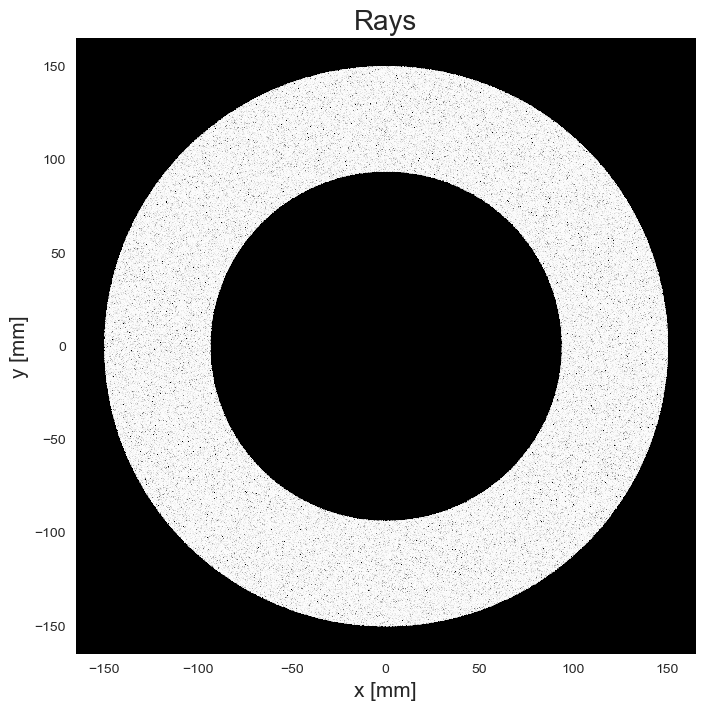

In [9]:
with sns.axes_style("ticks"):
#with sns.axes_style("whitegrid"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays", fontsize=20)
    #ax1.grid()

/Users/anh5866/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/Users/anh5866/anaconda3/lib/python3.11/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


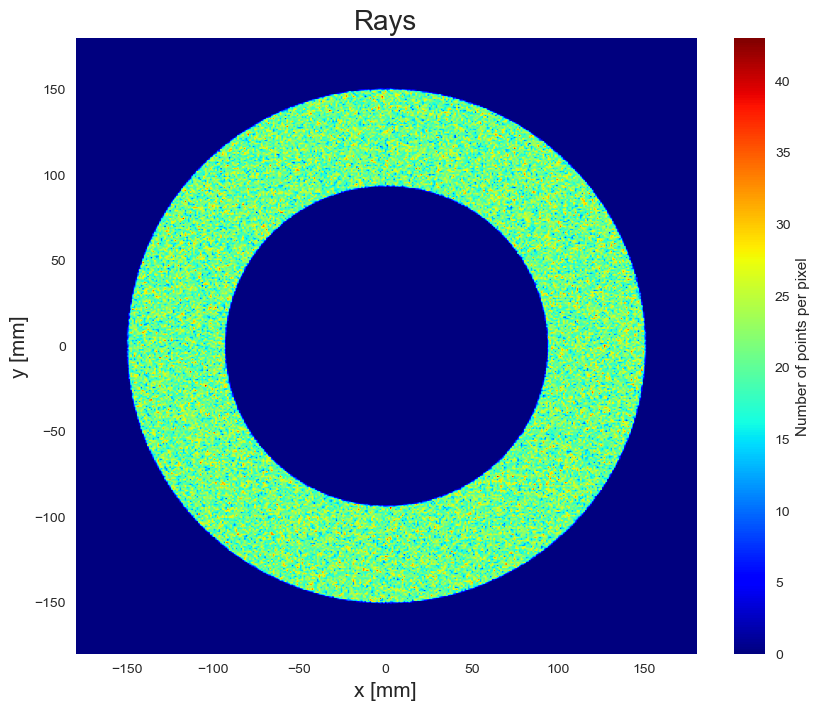

In [10]:
sns.set_style("ticks")
fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(1, 1, 1, projection='scatter_density')

#color_map = plt.get_cmap('plasma')
color_map = plt.get_cmap('jet')

density = ax1.scatter_density(rays[1], rays[2], cmap = color_map)
ax1.set_ylim(-180,180)
ax1.set_xlim(-180,180)

ax1.set_xlabel('x [mm]', fontsize=15)
ax1.set_ylabel('y [mm]', fontsize=15)

ax1.set_title("Rays", fontsize=20)

ax1.tick_params(axis='both',which='minor',direction='in')
ax1.tick_params(top=True,right=True)
ax1.tick_params(which='minor',top=True,right=True)

fig.colorbar(density, label='Number of points per pixel')

In [11]:
# Find centroid of rays and move rays down to center of beamline.
cen_optic = analyses.centroid(rays)
trans.transform(rays, 0, cen_optic[1], 0, 0, 0, 0)

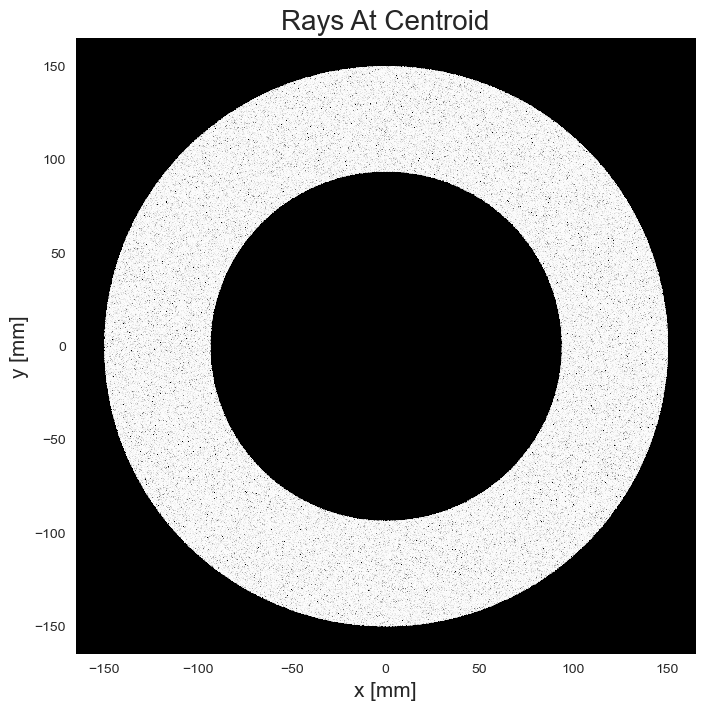

In [12]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays At Centroid", fontsize=20)
    #ax1.grid()

In [13]:
# Change ray direction cosines to emanate from source (48 m away). Long cell
# Change ray direction cosines to emanate from source (131 m away). PANTER
hyp = np.sqrt(L.to('mm').value**2 + rays[1]**2 + rays[2]**2)
l = rays[1]/hyp
m = rays[2]/hyp
n = -np.sqrt(1. - l**2 - m**2)
rays = [rays[0], rays[1], rays[2], rays[3],
        l, m, n, rays[7], rays[8], rays[9]]

In [14]:
# Shift rays back up.
trans.transform(rays, 0, -cen_optic[1], 0, 0, 0, 0)

# move global orgin to JET-X focus
trans.transform(rays, 0, 0, -z0.to('mm').value, 0, 0, 0)

rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([  -1.49573043,  -21.50076138, -134.0088127 , ..., -105.48823096,
          75.1356886 , -126.5023282 ]),
 array([-105.34144049,  139.14763884,   33.92115652, ...,  -34.05769054,
          95.96624665,  -73.9153841 ]),
 array([3500., 3500., 3500., ..., 3500., 3500., 3500.]),
 array([-1.14177858e-05, -1.64127855e-04, -1.02296747e-03, ...,
        -8.05253383e-04,  5.73554627e-04, -9.65666024e-04]),
 array([-0.00080402,  0.0010623 ,  0.00025905, ..., -0.00025987,
         0.00073268, -0.00056413]),
 array([-0.99999968, -0.99999942, -0.99999944, ..., -0.99999964,
        -0.99999957, -0.99999937]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.])]

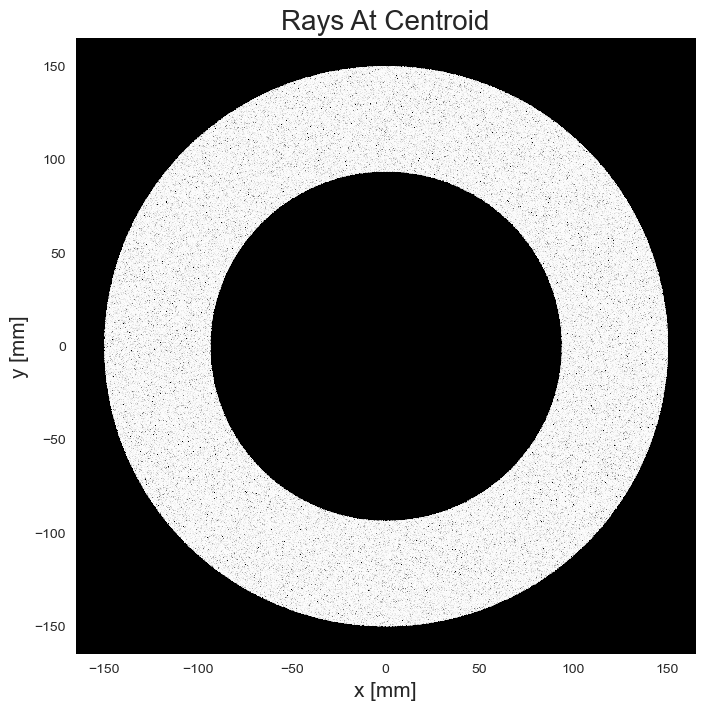

In [15]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    color_map = plt.get_cmap('plasma')
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)
    
    #cbar = plt.colorbar(rays)
    #cbar.set_label('Ec', fontsize=15)

    ax1.set_title("Rays At Centroid", fontsize=20)
    #ax1.grid()

In [16]:
def loc_rays(rays, rp_back, rp_front):
    
    # Find photons which will hit this mirror shell.
    r = np.sqrt(rays[1]**2 + rays[2]**2) #cartesian to polar transformation — "r" as radius for each of the rays
    # r = sqrt(x^2 + y^2)

    #this need to be edited. Another function perhaps ?
    ind = np.where((r > rp_back.to('mm').value) & (r < rp_front.to('mm').value))[0]
    #which rays fall within each shell (from each persspecive front radii to back radii)
    
    # Create new ray object with only these rays.
    ind_rays = [r[ind] for r in rays] #mask
    
    return ind_rays

In [17]:
#index/ fix this 

som1 = loc_rays(rays, rp_back[0], rp_front[0])
som2 = loc_rays(rays, rp_back[1], rp_front[1])
som3 = loc_rays(rays, rp_back[2], rp_front[2])
som4 = loc_rays(rays, rp_back[3], rp_front[3])
som5 = loc_rays(rays, rp_back[4], rp_front[4])
som6 = loc_rays(rays, rp_back[5], rp_front[5])
som7 = loc_rays(rays, rp_back[6], rp_front[6])
som8 = loc_rays(rays, rp_back[7], rp_front[7])
som9 = loc_rays(rays, rp_back[8], rp_front[8])
som10 = loc_rays(rays, rp_back[9], rp_front[9])
som11 = loc_rays(rays, rp_back[10], rp_front[10])
som12 = loc_rays(rays, rp_back[11], rp_front[11])

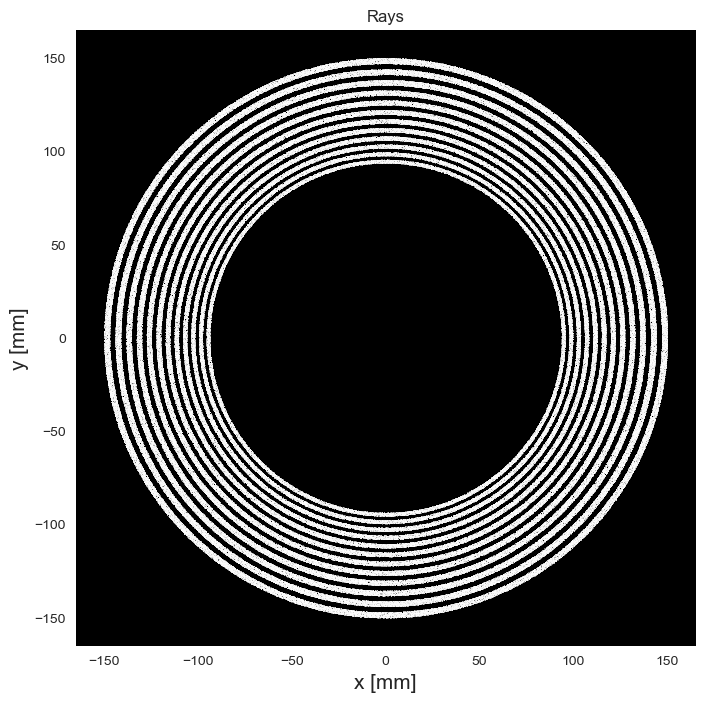

In [18]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [19]:
print(len(rays[1]))
print(len(som1[0]))


1000000
27184


In [20]:
def loc_primary(rays, r_int):
    # Propagate these photons to primary mirror.
    surfaces.wolterprimary(rays, r_int.to('mm').value, z0.to('mm').value)
    
    # Find which photons interact with this mirror.
    ind = np.where((rays[3] > (z0 + mirror_sep/2).to('mm').value) &
                   (rays[3] < (z0 + mirror_sep/2 + mirror_length).to('mm').value))[0]

    # Keep only the photons which interact with the actual size
    # of the mirror
    ind_rays = [r[ind] for r in rays]
    
    return ind_rays

In [21]:
som1 = loc_primary(som1, r_int[0])
som2 = loc_primary(som2, r_int[1])
som3 = loc_primary(som3, r_int[2])
som4 = loc_primary(som4, r_int[3])
som5 = loc_primary(som5, r_int[4])
som6 = loc_primary(som6, r_int[5])
som7 = loc_primary(som7, r_int[6])
som8 = loc_primary(som8, r_int[7])
som9 = loc_primary(som9, r_int[8])
som10 = loc_primary(som10, r_int[9])
som11 = loc_primary(som11, r_int[10])
som12 = loc_primary(som12, r_int[11])

In [22]:
som1

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 77.37737546, -45.82180541,  53.87464821, ...,  11.21680863,
         -4.16451917,  66.1706974 ]),
 array([-55.07646927, -83.40378659,  78.63932692, ...,  93.47723625,
         94.76731098, -67.08379162]),
 array([3708.96890914, 3737.06851174, 3761.68159549, ..., 3583.58121608,
        3690.99248752, 3595.55987563]),
 array([ 5.91610559e-04, -3.50418829e-04,  4.12079905e-04, ...,
         8.56791366e-05, -3.18366308e-05,  5.05488433e-04]),
 array([-0.00042099, -0.00063771,  0.00060161, ...,  0.00071413,
         0.00072458, -0.00051235]),
 array([-0.99999974, -0.99999974, -0.99999973, ..., -0.99999974,
        -0.99999974, -0.99999974]),
 array([-0.81467622,  0.48150267, -0.5651632 , ..., -0.11913778,
         0.04390136, -0.70222954]),
 array([ 0.57987868,  0.87641998, -0.82495302, ..., -0.9928555 ,
        -0.99901411,  0.71191966]),
 array([0.00658586, 0.00657307, 0.00656192, ..., 0.00664388, 0.00659409,
        0.00663827])]

In [23]:
trans.reflect(som1)
trans.reflect(som2)
trans.reflect(som3)
trans.reflect(som4)
trans.reflect(som5)
trans.reflect(som6)
trans.reflect(som7)
trans.reflect(som8)
trans.reflect(som9)
trans.reflect(som10)
trans.reflect(som11)
trans.reflect(som12)

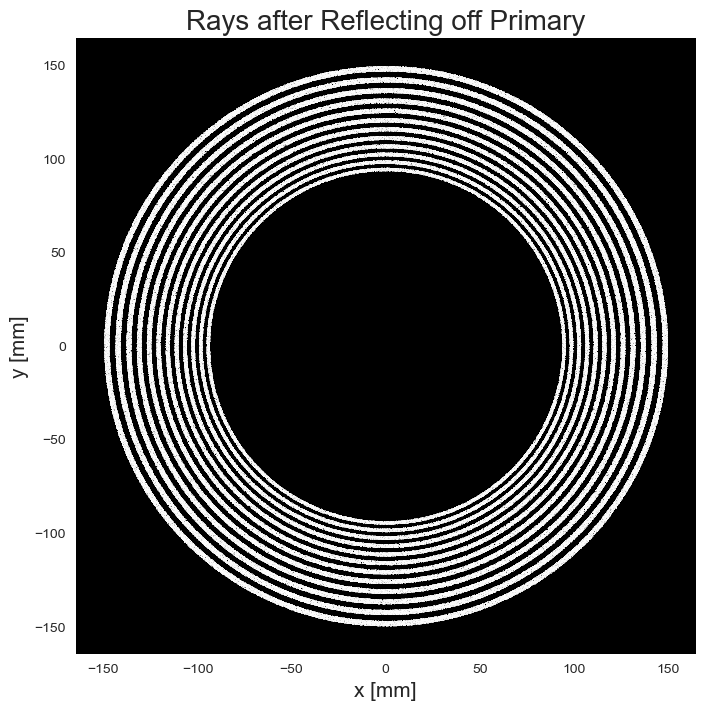

In [24]:
with sns.axes_style("ticks"):
    
   #matplotlib.rc('text',usetex=True)
   # matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Primary", fontsize=20)
    #ax1.grid()

In [25]:
som1

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 77.37737546, -45.82180541,  53.87464821, ...,  11.21680863,
         -4.16451917,  66.1706974 ]),
 array([-55.07646927, -83.40378659,  78.63932692, ...,  93.47723625,
         94.76731098, -67.08379162]),
 array([3708.96890914, 3737.06851174, 3761.68159549, ..., 3583.58121608,
        3690.99248752, 3595.55987563]),
 array([-0.01132215,  0.0066802 , -0.00782926, ..., -0.00166877,
         0.00061082, -0.00982851]),
 array([ 0.0080591 ,  0.01215925, -0.01142804, ..., -0.01390689,
        -0.01389969,  0.00996425]),
 array([-0.99990343, -0.99990376, -0.99990405, ..., -0.9999019 ,
        -0.99990321, -0.99990205]),
 array([-0.81467622,  0.48150267, -0.5651632 , ..., -0.11913778,
         0.04390136, -0.70222954]),
 array([ 0.57987868,  0.87641998, -0.82495302, ..., -0.9928555 ,
        -0.99901411,  0.71191966]),
 array([0.00658586, 0.00657307, 0.00656192, ..., 0.00664388, 0.00659409,
        0.00663827])]

In [26]:
def beck(num):
    som_list = [som1, som2, som3, som4, som5, som6, som7, som8, som9, som10, som11, som12]
    
    for som in som_list:
        ogre.beckmann_scatter(som, 0, 0, num)

beck(1.96e-4)  # used to be 1.48e-5

In [27]:
def loc_secondary(rays, r_int):
    
    # Propagate photons to the secondary mirror.
    surfaces.woltersecondary(rays, r_int.to('mm').value, z0.to('mm').value)

    # Find which photons will interact with hyperboloid.
    ind = np.where((rays[3] < (z0 - mirror_sep/2).to('mm').value) &
                   (rays[3] > (z0 - mirror_sep/2 - mirror_length).to('mm').value))[0]
    
    # keep only photons which interact with mirror.
    ind_rays = [r[ind] for r in rays]
    
    return ind_rays 

In [28]:
som1 = loc_secondary(som1, r_int[0])
som2 = loc_secondary(som2, r_int[1])
som3 = loc_secondary(som3, r_int[2])
som4 = loc_secondary(som4, r_int[3])
som5 = loc_secondary(som5, r_int[4])
som6 = loc_secondary(som6, r_int[5])
som7 = loc_secondary(som7, r_int[6])
som8 = loc_secondary(som8, r_int[7])
som9 = loc_secondary(som9, r_int[8])
som10 = loc_secondary(som10, r_int[9])
som11 = loc_secondary(som11, r_int[10])
som12 = loc_secondary(som12, r_int[11])

In [29]:
som1

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 72.22038997, -42.46479625,  49.55202434, ...,  10.91140823,
         -3.90968694,  64.08320392]),
 array([-51.40573097, -77.29544417,  72.33069813, ...,  90.93389019,
         88.95421839, -64.96750134]),
 array([3254.23330995, 3231.6861426 , 3206.15251265, ..., 3400.15399994,
        3273.70552048, 3383.67059837]),
 array([-0.01133953,  0.00664188, -0.00778036, ..., -0.00166481,
         0.00061063, -0.00985084]),
 array([ 0.00807147,  0.01208543, -0.011355  , ..., -0.01386434,
        -0.01392933,  0.00998673]),
 array([-0.99990313, -0.99990491, -0.99990526, ..., -0.9999025 ,
        -0.9999028 , -0.99990161]),
 array([-0.81452829,  0.48140532, -0.56505477, ..., -0.11911407,
         0.04390036, -0.702103  ]),
 array([ 0.57977286,  0.87626555, -0.82480598, ..., -0.99267714,
        -0.99883237,  0.71179147]),
 array([0.02017631, 0.02018907, 0.02020376, ..., 0.02009828, 0.02016545,
        0.02010672])]

In [30]:
trans.reflect(som1)
trans.reflect(som2)
trans.reflect(som3)
trans.reflect(som4)
trans.reflect(som5)
trans.reflect(som6)
trans.reflect(som7)
trans.reflect(som8)
trans.reflect(som9)
trans.reflect(som10)
trans.reflect(som11)
trans.reflect(som12)

In [31]:
def gauss(num):
    som_list = [som1, som2, som3, som4, som5, som6, som7, som8, som9, som10, som11, som12]

    for som in som_list:
        som[5] += np.random.normal(scale=num, size=len(som[5]))
        som[6] = -np.sqrt(1. - som[5]**2 - som[4]**2)

gauss(1.2e-5)  # originally 1.2e-5

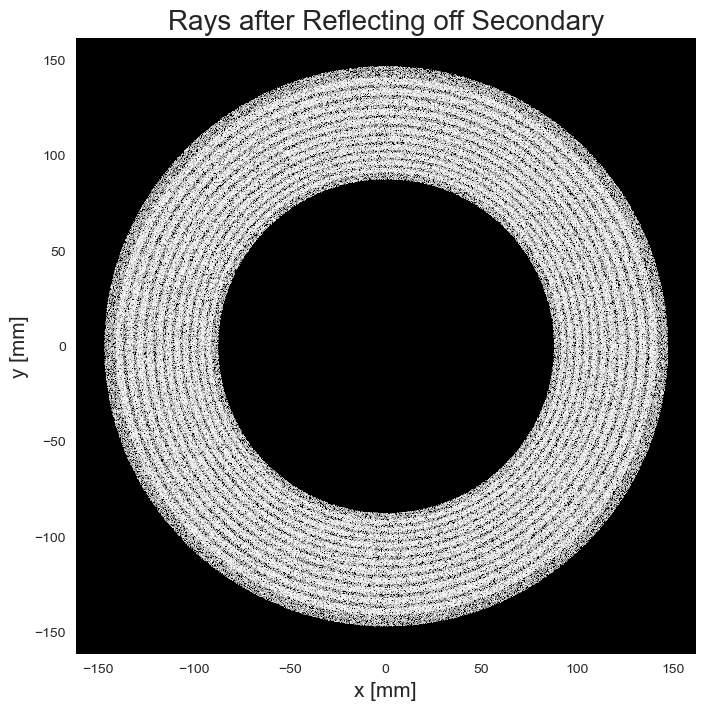

In [32]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(som1[1], som1[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som2[1], som2[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som3[1], som3[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som4[1], som4[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som5[1], som5[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som6[1], som6[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som7[1], som7[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som8[1], som8[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som9[1], som9[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som10[1], som10[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som11[1], som11[2], color="white", alpha=0.6, marker='.',  s=0.5)
    ax1.scatter(som12[1], som12[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays after Reflecting off Secondary", fontsize=20)
    #ax1.grid()

In [33]:
# List of som arrays to append
som_list = [som1, som2, som3, som4, som5, som6, som7, som8, som9, som10, som11, som12]

# Append all som arrays to new_rays
for som in som_list:
    new_rays = [np.append(new_rays[i], som[i]) for i in range(len(new_rays))]

print(len(new_rays[0]))


514729


In [34]:
rays = trans.copy_rays(new_rays)

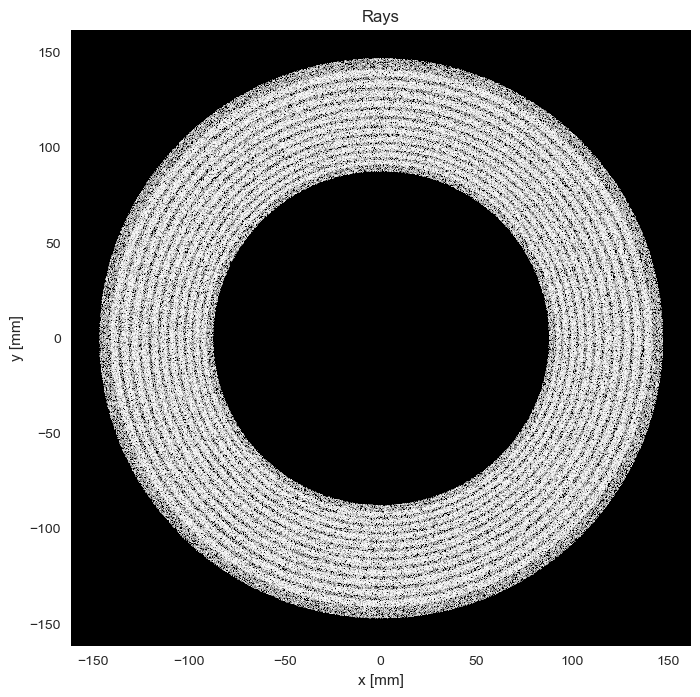

In [35]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.6, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    ax1.set_title("Rays")
    #ax1.grid()

In [36]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([  72.22038997,  -42.46479625,   49.55202434, ...,   67.89158934,
         -88.35206896, -130.33734759]),
 array([ -51.40573097,  -77.29544417,   72.33069813, ...,  119.96767548,
        -114.02997958,  -53.21541905]),
 array([3254.23330995, 3231.6861426 , 3206.15251265, ..., 3212.50210075,
        3415.0895637 , 3305.21651546]),
 array([-0.02153478,  0.01280356, -0.0150581 , ..., -0.02038575,
         0.0251331 ,  0.03829421]),
 array([ 0.01532553,  0.02332186, -0.02198777, ..., -0.0359897 ,
         0.03242014,  0.01564162]),
 array([-0.99965063, -0.99964602, -0.99964483, ..., -0.99914422,
        -0.99915828, -0.99914408]),
 array([-0.81452829,  0.48140532, -0.56505477, ..., -0.49227028,
         0.61217555,  0.92534379]),
 array([ 0.57977286,  0.87626555, -0.82480598, ..., -0.86986506,
         0.79009315,  0.3778085 ]),
 array([0.02017631, 0.02018907, 0.02020376, ..., 0.03169785, 0.03152632,
        0.03161644])]

In [37]:
surfaces.flat(rays)
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 2.11670228, -1.07306955,  1.25631892, ...,  2.34623747,
        -2.44795977, -3.65827404]),
 array([-1.51544104, -1.89982405,  1.80951661, ...,  4.25167079,
        -3.21901482, -1.47220793]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.02153478,  0.01280356, -0.0150581 , ..., -0.02038575,
         0.0251331 ,  0.03829421]),
 array([ 0.01532553,  0.02332186, -0.02198777, ..., -0.0359897 ,
         0.03242014,  0.01564162]),
 array([-0.99965063, -0.99964602, -0.99964483, ..., -0.99914422,
        -0.99915828, -0.99914408]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [38]:
# Go to the X-ray focus.
f0 = surfaces.focusX(rays) #put z to focus 
print(f0)

#might need to flat to make sure we are where we think we are

-95.25384858833128


In [39]:
#trans.transform(rays, 0, 0, 0, 0, 0, 0)
#surfaces.flat(rays)

In [40]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.06471474,  0.14695033, -0.1785322 , ...,  0.40275331,
        -0.05191814, -0.00747848]),
 array([-0.05511482,  0.32245956, -0.28564683, ...,  0.82057742,
        -0.12826994,  0.01899247]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.02153478,  0.01280356, -0.0150581 , ..., -0.02038575,
         0.0251331 ,  0.03829421]),
 array([ 0.01532553,  0.02332186, -0.02198777, ..., -0.0359897 ,
         0.03242014,  0.01564162]),
 array([-0.99965063, -0.99964602, -0.99964483, ..., -0.99914422,
        -0.99915828, -0.99914408]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [41]:
# Put optic focus at y=0.


#find mean of y -- finite source so the path length for the rays are different from one another, 
#will be shifted downwards by some amount. 


# each source has different focal length ; each has different magnification 

# ratios between size of image and sie of extra focual image with distance object/ distance sourse is same,
# sanity check; picture 05/27

cen_y = np.mean(rays[2])
print(cen_y)
trans.transform(rays, 0, cen_y, 0, 0, 0, 0)

# Copy rays to reference later.
of_rays = deepcopy(rays)

rays

-0.0007010621987100811


[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.06471474,  0.14695033, -0.1785322 , ...,  0.40275331,
        -0.05191814, -0.00747848]),
 array([-0.05441376,  0.32316062, -0.28494577, ...,  0.82127848,
        -0.12756888,  0.01969353]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([-0.02153478,  0.01280356, -0.0150581 , ..., -0.02038575,
         0.0251331 ,  0.03829421]),
 array([ 0.01532553,  0.02332186, -0.02198777, ..., -0.0359897 ,
         0.03242014,  0.01564162]),
 array([-0.99965063, -0.99964602, -0.99964483, ..., -0.99914422,
        -0.99915828, -0.99914408]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

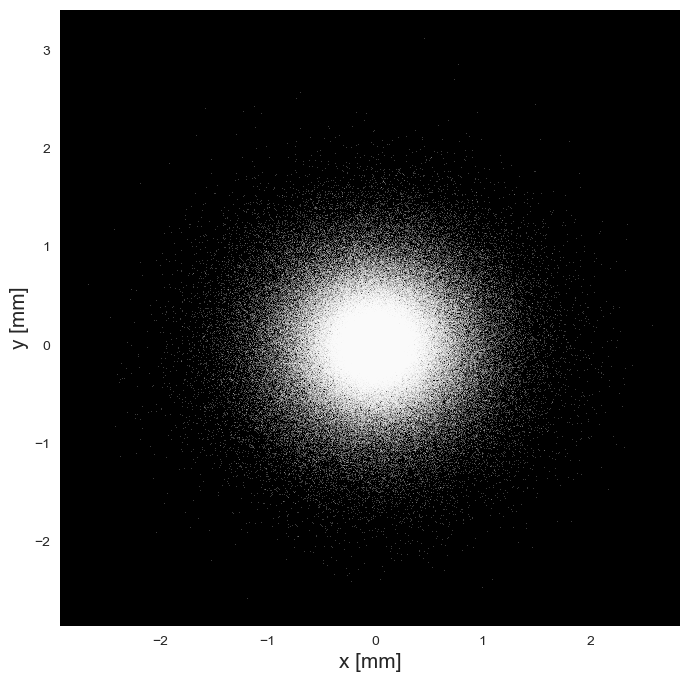

In [42]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]', fontsize=15)
    ax1.set_ylabel('y [mm]', fontsize=15)
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", alpha=0.3, marker='.',  s=0.5)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

## Grating Simulation

In [43]:
# Grating Parameters 
hub = 3000. * u.mm  # Hub length
# double check 

# convergence length from center of grating 
d = 315.15 * u.nm # [nm] At 3300 mm from grating hub.
d *= 3000 * u.mm / hub # Redefine to value at center of grating.
## finding a period, look into this 

gammy = 1.5 * u.deg  # Graze angle. #not gamma #eta
blaze = 0.575959 * u.rad  # Blaze angle. #33 degrees

yaw = 0.98 * u.deg  # Yaw of grating.
throw = hub / np.cos(gammy)

grat_length = 70 * u.mm
grat_width = 63 * u.mm

print(d)
print(throw)
#write grating equation anayltically 

315.15 nm
3001.028377472604 mm


In [44]:
# Calculate mean convergence angle of rays.
# 4*alpha 

r = np.mean(r_int) - cen_y * u.mm
z = z0 - f0 * u.mm

conv_ang = np.arctan(r/z)
print('Optic Convergence Angle: ' + str(conv_ang))

print(cen_y)

Optic Convergence Angle: 0.032933997496881875 rad
-0.0007010621987100811


In [45]:
# Find how far we need to move from focal plane.
z_grat = np.cos(abs(conv_ang)) * throw
r_grat = np.sin(abs(conv_ang)) * throw

print(z_grat)
print(r_grat)

2999.4009945748385 mm
98.81799501771262 mm


In [46]:
# Establish starting coordinates.
glob_coords = [trans.tr.identity_matrix()] * 4 #just how coords works when using transform 


print(glob_coords)

[array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]]), array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])]


In [47]:
# Move to grating location.
trans.transform(rays, 0, r_grat.to('mm').value, z_grat.to('mm').value, 0, 0, 0, coords=glob_coords)

In [48]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.06471474,  0.14695033, -0.1785322 , ...,  0.40275331,
        -0.05191814, -0.00747848]),
 array([-98.87240878, -98.4948344 , -99.10294079, ..., -97.99671653,
        -98.9455639 , -98.79830149]),
 array([-2999.40099457, -2999.40099457, -2999.40099457, ...,
        -2999.40099457, -2999.40099457, -2999.40099457]),
 array([-0.02153478,  0.01280356, -0.0150581 , ..., -0.02038575,
         0.0251331 ,  0.03829421]),
 array([ 0.01532553,  0.02332186, -0.02198777, ..., -0.0359897 ,
         0.03242014,  0.01564162]),
 array([-0.99965063, -0.99964602, -0.99964483, ..., -0.99914422,
        -0.99915828, -0.99914408]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [49]:
trans.transform(rays, 0, 0, 0, -np.pi/2, 0, 0, coords=glob_coords)
trans.transform(rays, 0, 0, 0, -conv_ang.to('rad').value, 0, 0, coords=glob_coords) #orthoganal to rays 
# The above puts +y pointed towards the focus.
#moer than 90 degrees 
 
# Put incidence angle onto grating.
trans.transform(rays, 0, 0, 0, -gammy.to('rad').value, 0, 0, coords=glob_coords)

# Get +y to point towards grating surface for radgrat function.
trans.transform(rays, 0, 0, 0, 0, 0, np.pi, coords=glob_coords) # x going into page
#set up for radgrat 
#which way in x grooves open up in function 


# Add yaw.
trans.transform(rays, 0, 0, 0, 0, 0, -yaw.to('rad').value, coords=glob_coords)

# Go to hub location.
trans.transform(rays, 0, -hub.to('mm').value, 0, 0, 0, 0, coords=glob_coords)
# Project photons onto x-y plane (the grating surface).
surfaces.flat(rays)

In [50]:
rays

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 10.5105972 ,  47.09892732, -16.31475057, ..., -77.86581168,
         58.31595311,  73.68292066]),
 array([1052.47846516,  955.18042533, 2107.1528699 , ..., 3433.09344589,
         854.976116  , 1049.97164958]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.0385837 ,  0.00424223,  0.03214556, ...,  0.03747804,
        -0.00810304, -0.02124551]),
 array([-0.99648494, -0.99659529, -0.99879406, ..., -0.99903037,
        -0.99578191, -0.99698396]),
 array([0.07435764, 0.08233972, 0.03710917, ..., 0.02310212, 0.0913933 ,
        0.07464324]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [51]:
diff_inds = np.array([])
waves = np.ones(len(rays[0])) * wave

ind = np.where((rays[2] > (hub - grat_length/2).to('mm').value) &
               (rays[2] < (hub + grat_length/2).to('mm').value))[0]

In [52]:
# Reflect photons which fall onto this grating.
print([r[ind] for r in rays])
trans.reflect(rays, ind=ind)
print([r[ind] for r in rays])
# Diffract photons.
trans.radgrat(rays, d.to('nm').value/hub.to('mm').value, 13, waves.to('nm').value, ind=ind) 
#only diffracted rays


#units 
#groove density 
#0 order

print([r[ind] for r in rays])

# Return back to original coordinate system.
#rays = trans.applyT(rays, glob_coords, inverse=True)

rays

[array([0., 0., 0., ..., 0., 0., 0.]), array([-10.23234947, -17.4912431 ,  17.76516369, ...,  72.41634641,
       -75.66184499,  74.04036367]), array([3027.15121749, 3024.32255098, 2985.41662455, ..., 3011.4645697 ,
       3022.0423651 , 2991.47634188]), array([0., 0., 0., ..., 0., 0., 0.]), array([ 0.02030625,  0.0227644 ,  0.01121812, ..., -0.00700113,
        0.04210925, -0.00767905]), array([-0.99945291, -0.99940687, -0.99959349, ..., -0.99963518,
       -0.99878042, -0.9996289 ]), array([0.02610643, 0.02583973, 0.02621084, ..., 0.0260864 , 0.02577757,
       0.02613611]), array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]), array([1., 1., 1., ..., 1., 1., 1.])]
[array([0., 0., 0., ..., 0., 0., 0.]), array([-10.23234947, -17.4912431 ,  17.76516369, ...,  72.41634641,
       -75.66184499,  74.04036367]), array([3027.15121749, 3024.32255098, 2985.41662455, ..., 3011.4645697 ,
       3022.0423651 , 2991.47634188]), array([0., 0., 0., ..., 0., 0., 0.]), array([ 0

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 10.5105972 ,  47.09892732, -16.31475057, ..., -77.86581168,
         58.31595311,  73.68292066]),
 array([1052.47846516,  955.18042533, 2107.1528699 , ..., 3433.09344589,
         854.976116  , 1049.97164958]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([ 0.0385837 ,  0.00424223,  0.03214556, ...,  0.03747804,
        -0.00810304, -0.02124551]),
 array([-0.99648494, -0.99659529, -0.99879406, ..., -0.99903037,
        -0.99578191, -0.99698396]),
 array([0.07435764, 0.08233972, 0.03710917, ..., 0.02310212, 0.0913933 ,
        0.07464324]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([1., 1., 1., ..., 1., 1., 1.])]

In [53]:
# rotation about x either 90 or - 90 

trans.transform(rays, 0, 0, 0, np.pi/2, 0, 0, coords=glob_coords)

In [54]:
surfaces.flat(rays) #tracing to focal plane 

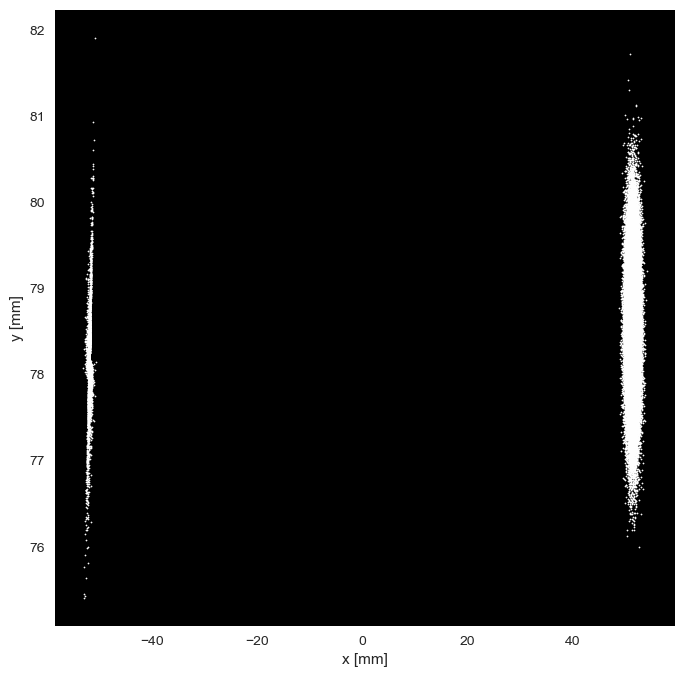

In [55]:
with sns.axes_style("ticks"):
    
    #matplotlib.rc('text',usetex=True)
    #matplotlib.rc('font',size=15)
    fig1,ax1 = plt.subplots(figsize=(8,8))
    

    ax1.set_xlabel('x [mm]')
    ax1.set_ylabel('y [mm]')
    
    ax1.set_facecolor('black')

    ax1.scatter(rays[1], rays[2], color="white", s=0.8)

    ax1.tick_params(axis='both',which='minor',direction='in')
    ax1.tick_params(top=True,right=True)
    ax1.tick_params(which='minor',top=True,right=True)

    #ax1.set_title("Rays @ Grating LSF Best Focus [Z=" + str(round(grat_focus, 2)) + " mm]")
    #ax1.grid()